# High-Fidelity Generative Image Compression

This colab can be used to compress images using HiFiC. This can also be achieved
by running `tfci.py`, as [explained in the README](https://github.com/tensorflow/compression/tree/master/models/hific#running-models-trained-by-us-locally).

Please visit [hific.github.io](https://hific.github.io) for more information.

## Setup Colab

In [6]:
# Installs the latest version of TFC compatible with the installed TF version.
!pip install tensorflow-compression~=$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d\.\d).*/\1.0/sg')

# Downloads the 'models' directory from Github.
![[ -e /tfc ]] || git clone https://github.com/tensorflow/compression /tfc
%cd /tfc/models

# Checks if tfci.py is available.
import tfci


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/tfc/models


## Enabling GPU

GPU should be enabled for this colab. If the next cell prints a warning, do the following:
- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down


In [7]:
import tensorflow as tf

if not tf.config.list_physical_devices('GPU'):
  print('WARNING: No GPU found. Might be slow!')
else:
  print('Found GPU.')

Found GPU.


## Imports and Definitions

In [8]:
import os
import zipfile
from google.colab import files
import collections
from PIL import Image
from IPython.display import Image as DisplayImage
from IPython.display import Javascript
from IPython.core.display import display, HTML
import tfci
import urllib.request

tf.get_logger().setLevel('WARN')  # Only show Warnings

FILES_DIR = '/content/test'
OUT_DIR = '/content/out'
DEFAULT_IMAGE_URL = ('https://storage.googleapis.com/hific/clic2020/'
                     'images/originals/ad249bba099568403dc6b97bc37f8d74.png')

os.makedirs(FILES_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

File = collections.namedtuple('File', ['full_path', 'num_bytes', 'bpp'])

def print_html(html):
  display(HTML(html + '<br/>'))

def make_cell_large():
  display(Javascript(
      '''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

def get_default_image(output_dir):
  output_path = os.path.join(output_dir, os.path.basename(DEFAULT_IMAGE_URL))
  print('Downloading', DEFAULT_IMAGE_URL, '\n->', output_path)
  urllib.request.urlretrieve(DEFAULT_IMAGE_URL, output_path)



## Load files

In [9]:
#@title Setup { vertical-output: false, run: "auto", display-mode: "form" }
#@markdown #### Custom Images
#@markdown Tick the following if you want to upload your own images to compress.
#@markdown Otherwise, a default image will be used.
#@markdown 
#@markdown **Note**: We support JPG and PNG (without alpha channels).
#@markdown 

upload_custom_images = True #@param {type:"boolean", label:"HI"}

if upload_custom_images:
  uploaded = files.upload()
  for name, content in uploaded.items():
    with open(os.path.join(FILES_DIR, name), 'wb') as fout:
      print('Writing', name, '...')
      fout.write(content)

#@markdown #### Select a model
#@markdown Different models target different bitrates.

model = 'hific-lo' #@param ["hific-lo", "hific-mi", "hific-hi"]



Saving True.png to True (2).png
Writing True.png ...


In [10]:
if 'upload_custom_images' not in locals():
  print('ERROR: Please run the previous cell!')
  # Setting defaults anyway.
  upload_custom_images = False
  model = 'hific-lo'

In [11]:
all_files = os.listdir(FILES_DIR)
if not upload_custom_images or not all_files:
  print('Downloading default image...')
  get_default_image(FILES_DIR)
  print()

all_files = os.listdir(FILES_DIR)
print(f'Got the following files ({len(all_files)}):')

for file_name in all_files:
  img = Image.open(os.path.join(FILES_DIR, file_name))
  w, h = img.size
  img = img.resize((w // 15, h // 15))
  print('- ' + file_name + ':')
  display(img)

Got the following files (1):
- True.png:


# Compress images

In [12]:
SUPPORTED_EXT = {'.png', '.jpg'}

all_files = os.listdir(FILES_DIR)
if not all_files:
  raise ValueError("Please upload images!")

def get_bpp(image_dimensions, num_bytes):
  w, h = image_dimensions
  return num_bytes * 8 / (w * h)

def has_alpha(img_p):
  im = Image.open(img_p)
  return im.mode == 'RGBA'

all_outputs = []
for file_name in all_files:
  if os.path.isdir(file_name):
    continue
  if not any(file_name.endswith(ext) for ext in SUPPORTED_EXT):
    print('Skipping', file_name, '...')
    continue
  full_path = os.path.join(FILES_DIR, file_name)
  if has_alpha(full_path):
    print('Skipping because of alpha channel:', file_name)
    continue
  file_name, _ = os.path.splitext(file_name)

  compressed_path = os.path.join(OUT_DIR, f'{file_name}_{model}.tfci')
  output_path = os.path.join(OUT_DIR, f'{file_name}_{model}.png')
  
  if os.path.isfile(output_path):
    print('Exists already:', output_path)
    num_bytes = os.path.getsize(compressed_path)
    all_outputs.append(
      File(output_path, num_bytes,
           get_bpp(Image.open(full_path).size, num_bytes)))
    continue

  print('Compressing', file_name, 'with', model, '...')
  tfci.compress(model, full_path, compressed_path)
  num_bytes = os.path.getsize(compressed_path)
  print(f'Compressed to {num_bytes} bytes.')

  print('Decompressing...')
  tfci.decompress(compressed_path, output_path)
  
  all_outputs.append(
      File(output_path, num_bytes,
           get_bpp(Image.open(full_path).size, num_bytes)))

print('All done!')

Compressing True with hific-lo ...
Compressed to 1215 bytes.
Decompressing...
All done!


# Show output

<IPython.core.display.Javascript object>

Showing /content/out/True_hific-lo.png | 1kB | 0.1483bpp


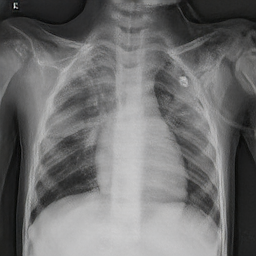

In [14]:
make_cell_large()  # Larger output window.

for file in all_outputs:
  print_html('<hr/>')
  print(f'Showing {file.full_path} | {file.num_bytes//1000}kB | {file.bpp:.4f}bpp')
  display(Image.open(file.full_path))
  print_html('<hr/>')

### Download all compressed images.

To download all images, run the following cell.

You can also use the _Files_ tab on the left to manually select images.

---

#### **Note**: the images are saved as PNGs and thus very large. The bitrate used by HiFiC is given in the name.

In [ ]:
ZIP = '/content/images.zip'

with zipfile.ZipFile(ZIP, 'w') as zf:
  for f in all_outputs:
    path_with_bpp = f.full_path.replace('.png', f'-{f.bpp:.3f}bpp.png')
    zf.write(f.full_path, os.path.basename(path_with_bpp))

files.download(ZIP) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import cv2
import matplotlib.pyplot as plt

src = cv2.imread('/content/test/True.png')
hfc = cv2.imread('/content/out/True_hific-lo.png')

In [16]:
import numpy as np
np.mean(np.square(src - hfc))

29.560155232747395

In [20]:
delta = src - hfc

In [33]:
cv2.imwrite('/content/deltahific.png',delta)

True

In [26]:
delta = delta[:,:,0]

In [32]:
delta

array([[243, 251, 251, ...,   1,   0, 255],
       [246, 242, 254, ...,   0, 255, 255],
       [242, 245,   1, ...,   1,   0, 254],
       ...,
       [  6,   6,   5, ...,   1,   0,   0],
       [  7,   5,   5, ...,   1,   0,   2],
       [  8,   4,   5, ...,   3,   1,   2]], dtype=uint8)

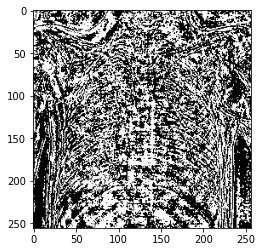

In [35]:
plt.imshow(delta,'gray')

In [36]:
src

array([[[44, 44, 44],
        [50, 50, 50],
        [46, 46, 46],
        ...,
        [37, 37, 37],
        [36, 36, 36],
        [36, 36, 36]],

       [[46, 46, 46],
        [42, 42, 42],
        [50, 50, 50],
        ...,
        [37, 37, 37],
        [36, 36, 36],
        [36, 36, 36]],

       [[41, 41, 41],
        [43, 43, 43],
        [50, 50, 50],
        ...,
        [37, 37, 37],
        [36, 36, 36],
        [36, 36, 36]],

       ...,

       [[36, 36, 36],
        [36, 36, 36],
        [36, 36, 36],
        ...,
        [36, 36, 36],
        [35, 35, 35],
        [35, 35, 35]],

       [[36, 36, 36],
        [36, 36, 36],
        [36, 36, 36],
        ...,
        [36, 36, 36],
        [35, 35, 35],
        [35, 35, 35]],

       [[36, 36, 36],
        [36, 36, 36],
        [36, 36, 36],
        ...,
        [36, 36, 36],
        [35, 35, 35],
        [35, 35, 35]]], dtype=uint8)

In [37]:
hfc

array([[[57, 55, 52],
        [55, 53, 52],
        [51, 50, 49],
        ...,
        [36, 37, 38],
        [36, 37, 39],
        [37, 38, 38]],

       [[56, 54, 52],
        [56, 55, 53],
        [52, 52, 49],
        ...,
        [37, 38, 38],
        [37, 37, 38],
        [37, 38, 38]],

       [[55, 54, 52],
        [54, 51, 49],
        [49, 47, 45],
        ...,
        [36, 37, 38],
        [36, 37, 39],
        [38, 39, 39]],

       ...,

       [[30, 32, 31],
        [30, 31, 30],
        [31, 32, 31],
        ...,
        [35, 34, 33],
        [35, 34, 33],
        [35, 34, 33]],

       [[29, 32, 30],
        [31, 32, 31],
        [31, 33, 33],
        ...,
        [35, 34, 33],
        [35, 34, 34],
        [33, 31, 31]],

       [[28, 31, 29],
        [32, 34, 32],
        [31, 32, 32],
        ...,
        [33, 33, 31],
        [34, 34, 33],
        [33, 33, 32]]], dtype=uint8)